# CARDS Article Reproduction

**Author:** Cristian Alexanther Rojas Cardenas
**ID**: 32775849

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-Preprocess" data-toc-modified-id="Load-and-Preprocess-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and Preprocess</a></span></li><li><span><a href="#Training-Models" data-toc-modified-id="Training-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training Models</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Roberta" data-toc-modified-id="Roberta-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Roberta</a></span></li></ul></li><li><span><a href="#Inference" data-toc-modified-id="Inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></span><ul class="toc-item"><li><span><a href="#Validation" data-toc-modified-id="Validation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Validation</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test</a></span></li></ul></li></ul></div>

In [1]:
# Load the required packages

import re
import torch
import unicodedata
import numpy as np
import pandas as pd

from IPython.display import display, Markdown, Latex

from scipy.special import softmax

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from simpletransformers.classification import ClassificationModel

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from cards.utils import read_csv
import cards.preprocess as pp
from cards.fit.logistic import fit_logistic_classifier

from tqdm.notebook import tqdm
pd.set_option('display.max_colwidth', None)
tqdm.pandas()

if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use GPU {}:'.format(
        torch.cuda.current_device()), torch.cuda.get_device_name(torch.cuda.current_device()))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

2022-10-23 01:50:46.579823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 01:50:46.615645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 01:50:46.615807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/opt/conda/envs/uni/lib/python3.8/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


There are 1 GPU(s) available.
We will use GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU


## Load and Preprocess

In [2]:
# Load and pre-process the text data
# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()

# Load the data
train = pd.read_csv('cards/data/training/training.csv')
train["PARTITION"] = "TRAIN"
valid = pd.read_csv('cards/data/training/validation.csv')
valid["PARTITION"] = "VALID"
test = pd.read_csv('cards/data/training/test.csv')
test["PARTITION"] = "TEST"

data = pd.concat([train, valid, test], ignore_index=True)

# Pre-process the text
data['roberta_preprocessed'] = data["text"].astype(str).apply(denoise_text)

data['lr_preprocessed'] = data["text"].progress_apply(
    lambda text: pp.tokenize(pp.denoise_text(str(text)), remove_stops=True))

# Load the label encoder
le = LabelEncoder()

# Encode the labels
data['label'] = le.fit_transform(data.claim)

data.head()

  0%|          | 0/28945 [00:00<?, ?it/s]

/opt/conda/envs/uni/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/envs/uni/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


,text,claim,PARTITION,roberta_preprocessed,lr_preprocessed,label
0,What do you do if you are a global warming alarmist and real-world temperatures do not warm as much as your climate model predicted?,5_1,TRAIN,What do you do if you are a global warming alarmist and real-world temperatures do not warm as much as your climate model predicted?,global warming alarmist real world temperatures warm much climate model predicted,16
1,"(2.) A sun-blocking volcanic aerosols component to explain the sudden but temporary cooling of global sea surface temperatures that are caused by catastrophic volcanic eruptions; and,",0_0,TRAIN,"(2.) A sun-blocking volcanic aerosols component to explain the sudden but temporary cooling of global sea surface temperatures that are caused by catastrophic volcanic eruptions; and,",2 sun blocking volcanic aerosols component explain sudden temporary cooling global sea surface temperatures caused catastrophic volcanic eruptions,0
2,"Now, I am very interested in the AMO, since it strongly influences Atlantic hurricanes, Arctic sea ice, and Greenland climate. We are already seeing a recovery of the Atlantic sector of the Arctic sea ice, and some hints of cooling in Greenland.",1_1,TRAIN,"Now, I am very interested in the AMO, since it strongly influences Atlantic hurricanes, Arctic sea ice, and Greenland climate. We are already seeing a recovery of the Atlantic sector of the Arctic sea ice, and some hints of cooling in Greenland.",interested amo since strongly influences atlantic hurricanes arctic sea ice greenland climate already seeing recovery atlantic sector arctic sea ice hints cooling greenland,1
3,"Dr. Christy addressed recent challenges to the satellite data. One paper claimed to show that the satellite data actually show warming. The author, however, used only 9 percent on the satellite data the data with the least coverage and the greatest error. Each attack of the satellite data has disregarded the fact that this record is independently validated by a 98 percent correspondence with the radiosonde balloon data. These same scientists seem to put a lot of credence in surface temperature data that only cover 10 percent of the globe, nearly all of which is in the Northern Hemisphere.",0_0,TRAIN,"Dr. Christy addressed recent challenges to the satellite data. One paper claimed to show that the satellite data actually show warming. The author, however, used only 9 percent on the satellite data the data with the least coverage and the greatest error. Each attack of the satellite data has disregarded the fact that this record is independently validated by a 98 percent correspondence with the radiosonde balloon data. These same scientists seem to put a lot of credence in surface temperature data that only cover 10 percent of the globe, nearly all of which is in the Northern Hemisphere.",dr. christy addressed recent challenges satellite data one paper claimed show satellite data actually show warming author however used 9 percent satellite data data least coverage greatest error attack satellite data disregarded fact record independently validated 98 percent correspondence radiosonde balloon data scientists seem put lot credence surface temperature data cover 10 percent globe nearly northern hemisphere,0
4,"After a brief protest from Massachusetts Republicans in their state Senate, the commonwealth is on the verge of changing its law to allow Gov. Deval Patrick (D) to appoint an interim Senator until the special election to fill the late Sen. Edward Kennedy's seat can be held in January.",0_0,TRAIN,"After a brief protest from Massachusetts Republicans in their state Senate, the commonwealth is on the verge of changing its law to allow Gov. Deval Patrick (D) to appoint an interim Senator until the special election to fill the late Sen. Edward Kennedy's seat can be held in January.",brief protest massachusetts republicans state senate commonwealth verge changing law allow gov. deval patrick appoint interim senator s

## Training Models
### Logistic Regression

In [3]:
def fit_logistic_classifier(X, y):

    # Vectorize
    vectorizer = TfidfVectorizer(min_df=3,  max_features=None,
                                strip_accents='unicode',
                                ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1)

    # Fit final logistic classifier. Hyperparameters tuned via grid search using
    #  10-fold cross-validation
    clf_logit = LogisticRegression(C=7.96,
                                solver='lbfgs',
                                multi_class='ovr',
                                max_iter=200,
                                class_weight='balanced')
    
    pipe = Pipeline([('vectorizer', vectorizer), ('clf_logit', clf_logit)])
    pipe.fit(X, y)

    return pipe

# Fit the model
data_train = data.loc[data.PARTITION == "TRAIN"]
lr_model = fit_logistic_classifier(data_train.lr_preprocessed, data_train.label)

data['lr_pred'] = le.inverse_transform(lr_model.predict(data.lr_preprocessed))
data['lr_proba'] = lr_model.predict_proba(data.lr_preprocessed).tolist()

/opt/conda/envs/uni/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Roberta

In [6]:
# Define the model 
architecture = 'roberta'
# model_name = 'CARDS_RoBERTa_Classifier'
model_name = "cards/models/CARDS_RoBERTa_Classifier"

# Load the classifier
roberta_model = ClassificationModel(architecture, model_name)

# Predict the labels
predictions, raw_outputs = roberta_model.predict(list(data.roberta_preprocessed))

data['roberta_pred'] = le.inverse_transform(predictions)
data['roberta_proba'] = [softmax(element[0]) for element in raw_outputs]

Some weights of the model checkpoint at cards/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/28945 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1072 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/3633 [00:00<?, ?it/s]

## Inference

**Logistic Regression**

Accuracy: 0.976873186550606
AUC: 0.9984591085973661
              precision    recall  f1-score   support

         0_0       1.00      0.97      0.98     16302
         1_1       0.91      1.00      0.95       333
         1_2       0.96      0.99      0.98       147
         1_3       0.92      1.00      0.96       229
         1_4       0.94      1.00      0.97       483
         1_6       0.88      1.00      0.94       189
         1_7       0.94      1.00      0.97       427
         2_1       0.93      1.00      0.96       788
         2_3       0.90      1.00      0.95       339
         3_1       0.94      0.99      0.96       207
         3_2       0.94      0.99      0.97       337
         3_3       0.96      1.00      0.98       323
         4_1       0.96      1.00      0.98       328
         4_2       0.96      0.99      0.98       190
         4_4       0.90      1.00      0.95       245
         4_5       0.92      1.00      0.96       182
         5_1       0.92      

**Roberta**

Accuracy: 0.9674005803038062
AUC: 0.9966487520899453
              precision    recall  f1-score   support

         0_0       0.99      0.97      0.98     16302
         1_1       0.99      0.88      0.93       333
         1_2       0.90      0.95      0.92       147
         1_3       0.94      0.97      0.95       229
         1_4       0.94      0.98      0.96       483
         1_6       0.99      0.98      0.99       189
         1_7       0.94      0.98      0.96       427
         2_1       0.91      0.99      0.94       788
         2_3       0.93      0.96      0.94       339
         3_1       0.89      0.94      0.91       207
         3_2       0.97      0.98      0.97       337
         3_3       0.96      1.00      0.98       323
         4_1       0.81      0.95      0.87       328
         4_2       0.94      0.80      0.86       190
         4_4       0.88      0.97      0.92       245
         4_5       0.96      0.94      0.95       182
         5_1       0.90     

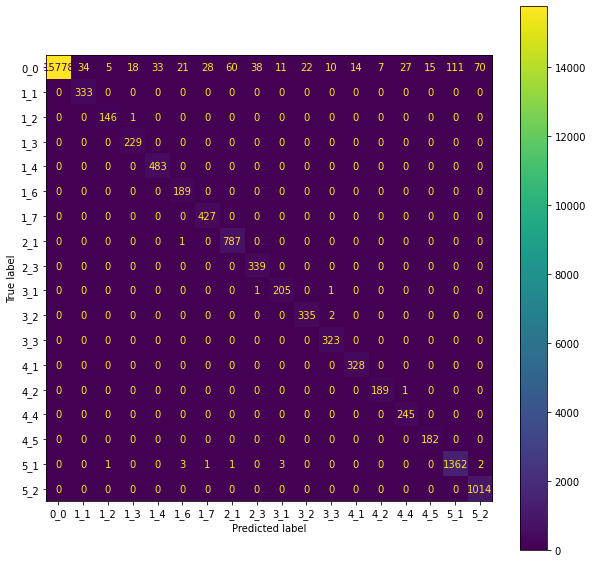

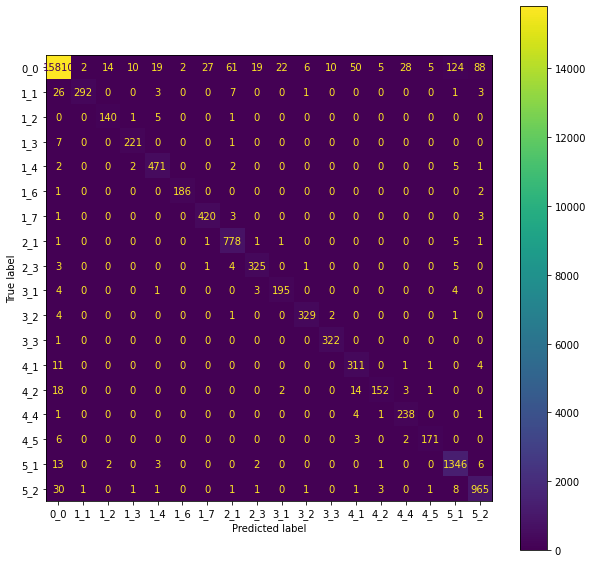

In [8]:
def report(y_true, y_pred, scores,  classes):
    
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores, multi_class="ovr", average="weighted")
    
    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    print(classification_report(le.transform(y_true), le.transform(y_pred), target_names=classes))
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(ax=ax)   

classes = le.classes_
data_valid= data[data.PARTITION=="TRAIN"]

display(Markdown("**Logistic Regression**"))
report(data_valid.claim, data_valid['lr_pred'].values, 
       np.stack(data_valid['lr_proba'].values, axis=0), classes)

display(Markdown("**Roberta**"))
report(data_valid.claim, data_valid['roberta_pred'].values, 
       np.stack(data_valid['roberta_proba'].values, axis=0), classes)

### Validation

**Logistic Regression**

Accuracy: 0.8165067178502879
AUC: 0.936993527319189
              precision    recall  f1-score   support

         0_0       0.92      0.88      0.90      1812
         1_1       0.72      0.89      0.80        37
         1_2       0.41      0.44      0.42        16
         1_3       0.70      0.76      0.73        25
         1_4       0.64      0.69      0.66        54
         1_6       0.61      0.90      0.73        21
         1_7       0.67      0.81      0.73        47
         2_1       0.57      0.70      0.63        88
         2_3       0.57      0.74      0.64        38
         3_1       0.68      0.65      0.67        23
         3_2       0.79      0.87      0.82        38
         3_3       0.92      0.92      0.92        36
         4_1       0.48      0.44      0.46        36
         4_2       0.32      0.38      0.35        21
         4_4       0.47      0.63      0.54        27
         4_5       0.56      0.50      0.53        20
         5_1       0.64      

**Roberta**

Accuracy: 0.8606525911708254
AUC: 0.9591627835629214
              precision    recall  f1-score   support

         0_0       0.94      0.90      0.92      1812
         1_1       0.96      0.73      0.83        37
         1_2       0.72      0.81      0.76        16
         1_3       0.88      0.84      0.86        25
         1_4       0.80      0.83      0.82        54
         1_6       0.95      0.90      0.93        21
         1_7       0.78      0.89      0.83        47
         2_1       0.73      0.82      0.77        88
         2_3       0.69      0.76      0.72        38
         3_1       0.77      0.74      0.76        23
         3_2       0.90      0.92      0.91        38
         3_3       0.94      0.94      0.94        36
         4_1       0.40      0.56      0.47        36
         4_2       0.60      0.57      0.59        21
         4_4       0.50      0.48      0.49        27
         4_5       0.70      0.70      0.70        20
         5_1       0.64     

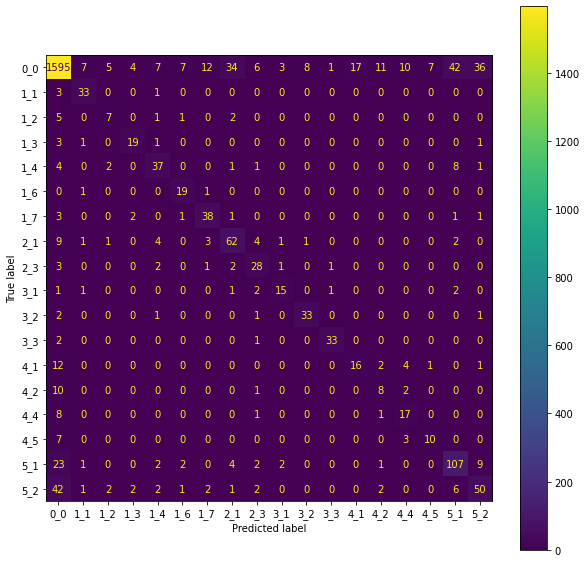

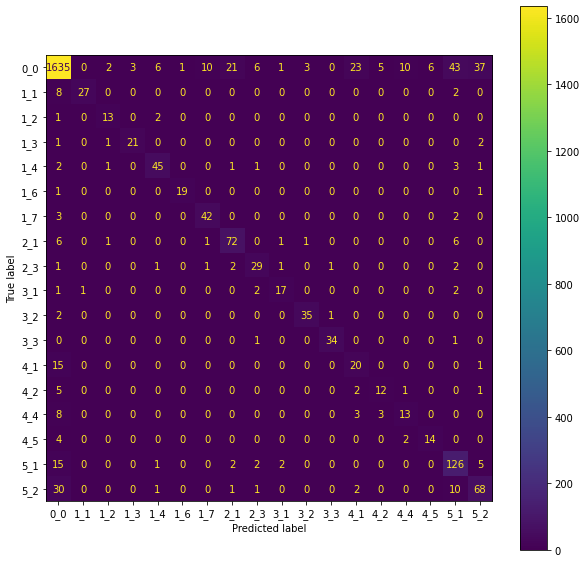

In [9]:
classes = le.classes_
data_valid= data[data.PARTITION=="VALID"]

display(Markdown("**Logistic Regression**"))
report(data_valid.claim, data_valid['lr_pred'].values, 
       np.stack(data_valid['lr_proba'].values, axis=0), classes)

display(Markdown("**Roberta**"))
report(data_valid.claim, data_valid['roberta_pred'].values, 
       np.stack(data_valid['roberta_proba'].values, axis=0), classes)

### Test

<img src="images/image.png" alt="drawing" width="600"/>

**Logistic Regression**

Accuracy: 0.8326446280991735
AUC: 0.9570167002152157
              precision    recall  f1-score   support

         0_0       0.89      0.95      0.92      1754
         1_1       0.74      0.76      0.75        51
         1_2       0.81      0.62      0.70        21
         1_3       0.84      0.70      0.76        30
         1_4       0.66      0.67      0.66        69
         1_6       0.64      0.96      0.77        26
         1_7       0.82      0.71      0.76        65
         2_1       0.71      0.78      0.75       124
         2_3       0.61      0.71      0.65        48
         3_1       0.64      0.62      0.63        26
         3_2       0.86      0.88      0.87        49
         3_3       0.90      0.98      0.94        46
         4_1       0.74      0.41      0.53        64
         4_2       0.61      0.41      0.49        34
         4_4       0.71      0.69      0.70        39
         4_5       0.76      0.53      0.62        36
         5_1       0.72     

**Roberta**

Accuracy: 0.8639807162534435
AUC: 0.9672098662438849
              precision    recall  f1-score   support

         0_0       0.90      0.95      0.92      1754
         1_1       0.92      0.65      0.76        51
         1_2       0.70      0.76      0.73        21
         1_3       0.92      0.73      0.81        30
         1_4       0.82      0.67      0.74        69
         1_6       0.92      0.92      0.92        26
         1_7       0.93      0.85      0.89        65
         2_1       0.83      0.85      0.84       124
         2_3       0.69      0.77      0.73        48
         3_1       0.77      0.77      0.77        26
         3_2       0.98      0.92      0.95        49
         3_3       0.90      0.96      0.93        46
         4_1       0.69      0.56      0.62        64
         4_2       0.78      0.41      0.54        34
         4_4       0.72      0.72      0.72        39
         4_5       0.72      0.50      0.59        36
         5_1       0.78     

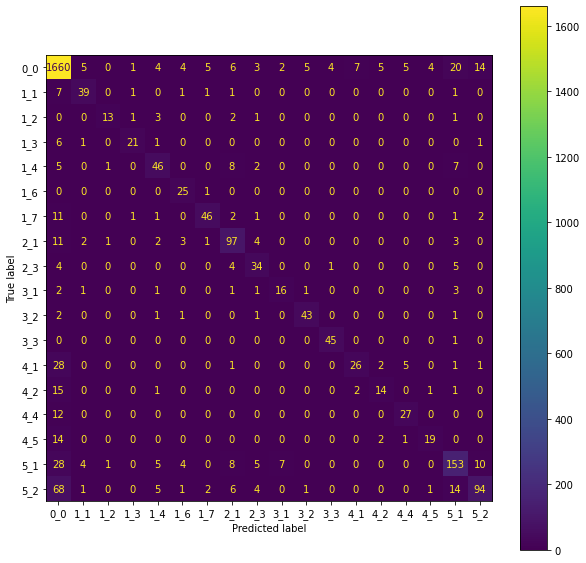

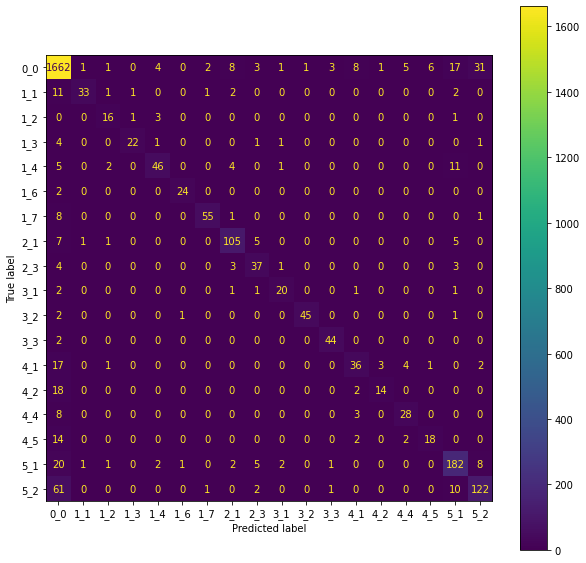

In [10]:
classes = le.classes_
data_test = data[data.PARTITION=="TEST"].copy(deep=True)

display(Markdown("**Logistic Regression**"))
report(data_test.claim, data_test['lr_pred'].values, 
       np.stack(data_test['lr_proba'].values, axis=0), classes)

display(Markdown("**Roberta**"))
report(data_test.claim, data_test['roberta_pred'].values, 
       np.stack(data_test['roberta_proba'].values, axis=0), classes)

In [11]:
data_test["score_diff"] = abs(data_test.lr_proba.apply(max) - data_test.roberta_proba.apply(max))

In [ ]:
(
    data_test[data_test.claim == data_test.roberta_pred]
    .sort_values("score_diff", ascending=False)
)[["text", "claim", "lr_pred", "roberta_pred", "score_diff"]][:10]

# 2.1 "Its geological"
# 5.2 "Proxies are unreliable" -> "Environmentalist are biased" 
# 1.1 "Its the temperature" -> "No claim"

In [ ]:
(
    data_test[data_test.claim != data_test.roberta_pred]
    .sort_values("score_diff", ascending=False)
)[["text", "claim", "lr_pred", "roberta_pred", "score_diff"]][:10]

# 2.1.4 "Past climate change" -> "No claim"
# 2.3.3 "CO2 lags climate" -> 5.1.4 "Models are unreliable"
# 1.4 "Hiatus on warning" -> 2.1 "Past Climate change Its geological" -> 5.1 "Proxies are unrealiable?"

In [12]:
data.to_csv("CARDS_scored.csv")